# Xenium Colon Preprocessing Tutorial

This end-to-end tutorial demonstrates how to convert a raw Xenium drop into cleaned AnnData objects, curated annotations, QC figures, and multi-scale image patches without exposing any absolute paths.

## Directory Layout

This notebook expects the following relative structure inside `Xenium_colon_wsi`, which should live next to this tutorial file:

```
Xenium_colon_wsi/
├─ Xenium_data_Human/<sample>/outs/...
├─ Xenium_processed/original_0.2125mpp/...
├─ Xenium_processed/resampled_0.25mpp/...
└─ Xenium_processed/extracted_patches/...
```

You can replace your sample folder with `Xenium_colon_wsi`, then run the steps below from the top.

### Step 1 – Configure paths and sample metadata

In [1]:
# ===== Core configuration (edit SAMPLE_NAME to switch datasets) =====
from pathlib import Path
import re

TUTORIAL_ROOT = Path.cwd()
DATA_ROOT = TUTORIAL_ROOT / "Xenium_colon_wsi"

BASE_DATASET_ROOT = DATA_ROOT / "A_Xenium_data_Human"
SAMPLE_NAME = "Colon_Preview_Data_Cancer+pre-designed+add-on"  # change this line to point at another sample

PROCESSED_ROOT = DATA_ROOT / "Xenium_processed"
ORIG_ROOT = PROCESSED_ROOT / "original_0.2125mpp"
RESAMPLED_ROOT = PROCESSED_ROOT / "resampled_0.25mpp"
PATCH_ROOT = PROCESSED_ROOT / "extracted_patches"


def _slug(s: str) -> str:
    """Convert a sample name into a filesystem-friendly slug."""
    return re.sub(r"[^A-Za-z0-9._+\-]+", "-", s)


DATASET_DIR = BASE_DATASET_ROOT / SAMPLE_NAME
SAMPLE = DATASET_DIR.name
SAMPLE_SLUG = _slug(SAMPLE)

outs_dir_candidate = DATASET_DIR / "outs"
GLOBAL_OUTS_DIR = DATA_ROOT / "outs"
if outs_dir_candidate.exists():
    OUTS_DIR = outs_dir_candidate
elif GLOBAL_OUTS_DIR.exists():
    OUTS_DIR = GLOBAL_OUTS_DIR
else:
    OUTS_DIR = DATASET_DIR

h5_path = OUTS_DIR / "cell_feature_matrix.h5"
cells_pq = OUTS_DIR / "cells.parquet"
cells_csv = OUTS_DIR / "cells.csv.gz"
metrics_csv = OUTS_DIR / "metrics_summary.csv"

he_candidate = DATASET_DIR / "Xenium_V1_hColon_Cancer_Add_on_FFPE_he_image.ome.tif"
align_candidate = DATASET_DIR / "Xenium_V1_hColon_Cancer_Add_on_FFPE_he_imagealignment.csv"
if not he_candidate.exists():
    he_candidate = DATA_ROOT / "Xenium_V1_hColon_Cancer_Add_on_FFPE_he_image.ome.tif"
if not align_candidate.exists():
    align_candidate = DATA_ROOT / "Xenium_V1_hColon_Cancer_Add_on_FFPE_he_imagealignment.csv"
he_ome = he_candidate
align_csv = align_candidate

MPP_MIP_DEFAULT = 0.2125

RUN_NAME = f"Xenium_{SAMPLE_SLUG}"
JSON_PREFIX = f"Xenium_{SAMPLE_SLUG}"
MPP_TARGET = 0.25
CONF_MIN = 0.60
PATCH_SIZE = 224
RNG_SEED = 20251006

OUT_DIR = ORIG_ROOT / SAMPLE
HE_DIR = OUT_DIR / "HE"
JSON_DIR = OUT_DIR / "json"
WORK_DIR = OUT_DIR / "work"

for d in [HE_DIR, JSON_DIR, WORK_DIR, WORK_DIR / "qc"]:
    d.mkdir(parents=True, exist_ok=True)

assert h5_path.exists(), f"Missing {h5_path}"
assert (cells_pq.exists() or cells_csv.exists()), "cells.parquet or cells.csv.gz is required"
assert he_ome.exists() and align_csv.exists(), "Missing H&E image or alignment CSV"

print(f"[CFG] SAMPLE={SAMPLE} | DATASET_DIR={DATASET_DIR}")
print(f"[IO] OUTS_DIR={OUTS_DIR}")
print(f"[OUT] ORIG_ROOT={ORIG_ROOT}")
print(f"[OUT] RESAMPLED_ROOT={RESAMPLED_ROOT}")
print(f"[OUT] PATCH_ROOT={PATCH_ROOT}")
print(f"[EXP] RUN_NAME={RUN_NAME}")
print(f"[EXP] JSON_PREFIX={JSON_PREFIX}")


[CFG] SAMPLE=Colon_Preview_Data_Cancer+pre-designed+add-on | DATASET_DIR=/data/Data_for_Nuclass_training/Nuclass/preprocess_tutorial/Xenium_colon_wsi/A_Xenium_data_Human/Colon_Preview_Data_Cancer+pre-designed+add-on
[IO] OUTS_DIR=/data/Data_for_Nuclass_training/Nuclass/preprocess_tutorial/Xenium_colon_wsi/outs
[OUT] ORIG_ROOT=/data/Data_for_Nuclass_training/Nuclass/preprocess_tutorial/Xenium_colon_wsi/Xenium_processed/original_0.2125mpp
[OUT] RESAMPLED_ROOT=/data/Data_for_Nuclass_training/Nuclass/preprocess_tutorial/Xenium_colon_wsi/Xenium_processed/resampled_0.25mpp
[OUT] PATCH_ROOT=/data/Data_for_Nuclass_training/Nuclass/preprocess_tutorial/Xenium_colon_wsi/Xenium_processed/extracted_patches
[EXP] RUN_NAME=Xenium_Colon_Preview_Data_Cancer+pre-designed+add-on
[EXP] JSON_PREFIX=Xenium_Colon_Preview_Data_Cancer+pre-designed+add-on


### Step 2 – Load expression counts and spatial tables

This cell reads the Xenium matrix plus the `cells.parquet`/`cells.csv.gz` file, aligns indices, and stores the raw AnnData object under `work/`.

In [2]:
import json, os, warnings
import numpy as np, pandas as pd
import scanpy as sc

warnings.filterwarnings('ignore', message='Some cells have zero counts', category=UserWarning)
warnings.filterwarnings('ignore', message="`flavor='seurat_v3'` expects raw count data, but non-integers were found.", category=UserWarning)
sc.set_figure_params(dpi=120, facecolor="white")

# Load the count matrix (Xenium h5) and ensure unique gene identifiers.
adata = sc.read_10x_h5(str(h5_path))
adata.var_names_make_unique()

# Load per-cell metadata with spatial coordinates (microns).
if cells_pq.exists():
    cells = pd.read_parquet(cells_pq)
else:
    cells = pd.read_csv(cells_csv, compression="gzip")

# Align indices between AnnData and the cell table.
if "cell_id" in cells.columns:
    cells["cell_id"] = cells["cell_id"].astype(str)
    cells = cells.set_index("cell_id", drop=False)

adata.obs.index = adata.obs.index.astype(str)
cells = cells.loc[adata.obs_names, :]

# Inject spatial coordinates (micron space) into AnnData.
for c in ["x_centroid", "y_centroid"]:
    assert c in cells.columns, f"missing {c} in cells table"
adata.obs[["x_micron", "y_micron"]] = cells[["x_centroid", "y_centroid"]].values

# Optional auxiliary fields if present.
for c in ["transcript_counts", "control_probe_counts", "nucleus_area", "cell_area"]:
    if c in cells.columns:
        adata.obs[c] = cells[c].values

print(adata)
adata.write(WORK_DIR / "adata.raw.h5ad", compression="lzf")
print(f"[SAVE] {WORK_DIR / 'adata.raw.h5ad'}")


AnnData object with n_obs × n_vars = 587115 × 425
    obs: 'x_micron', 'y_micron', 'transcript_counts', 'control_probe_counts', 'nucleus_area', 'cell_area'
    var: 'gene_ids', 'feature_types', 'genome'
[SAVE] /data/Data_for_Nuclass_training/Nuclass/preprocess_tutorial/Xenium_colon_wsi/Xenium_processed/original_0.2125mpp/Colon_Preview_Data_Cancer+pre-designed+add-on/work/adata.raw.h5ad


### Step 3 – Record acquisition metadata

Capture micron-per-pixel information and cell/gene counts for downstream bookkeeping.

In [3]:
import pandas as pd, json

mpp_mip = MPP_MIP_DEFAULT
if metrics_csv.exists():
    ms = pd.read_csv(metrics_csv)
    candidates = [c for c in ms.columns if "micron" in c.lower() and "pixel" in c.lower()]
    if candidates:
        val = float(ms[candidates[0]].iloc[0])
        if val > 0:
            mpp_mip = val

metrics = {
    "sample": SAMPLE,
    "micron_per_mip_pixel": mpp_mip,
    "n_cells": int(adata.n_obs),
    "n_genes": int(adata.n_vars),
}
with open(WORK_DIR / "metrics.json", "w") as f:
    json.dump(metrics, f, indent=2)
print("[METRICS]", metrics)


[METRICS] {'sample': 'Colon_Preview_Data_Cancer+pre-designed+add-on', 'micron_per_mip_pixel': 0.2125, 'n_cells': 587115, 'n_genes': 425}


### Step 4 – Plot quick QC histograms

Visualize transcripts-per-cell and genes-per-cell distributions before deeper processing.

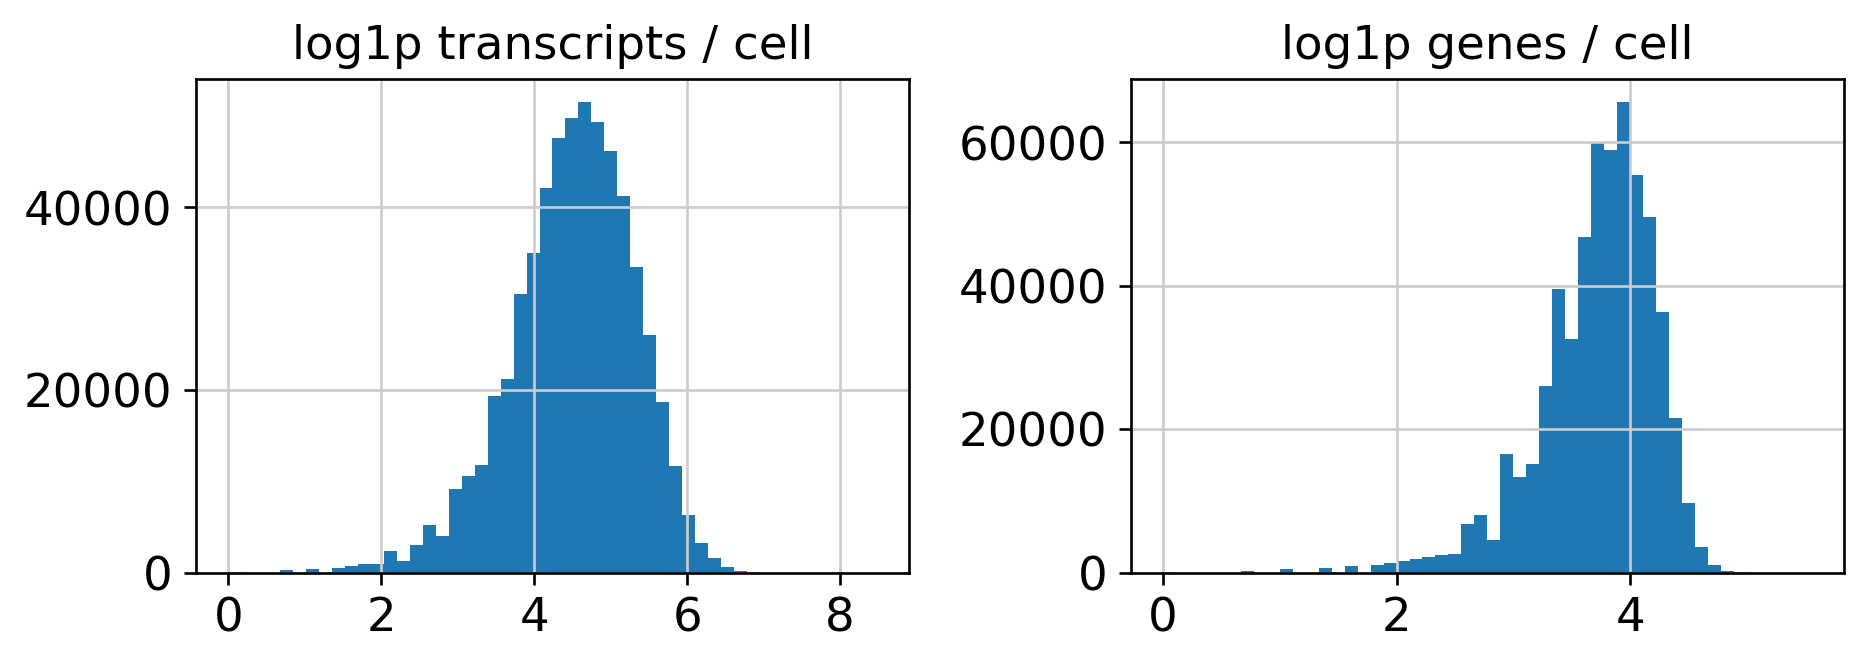

[FIG] /data/Data_for_Nuclass_training/Nuclass/preprocess_tutorial/Xenium_colon_wsi/Xenium_processed/original_0.2125mpp/Colon_Preview_Data_Cancer+pre-designed+add-on/work/qc/qc_hist.png


In [4]:
import numpy as np, matplotlib.pyplot as plt
from scipy import sparse

# Quick distributions for transcripts-per-cell and genes-per-cell.
X = adata.X
if sparse.issparse(X):
    adata.obs["n_transcripts"] = X.sum(axis=1).A1
    adata.obs["n_genes"] = (X > 0).sum(axis=1).A1
else:
    adata.obs["n_transcripts"] = X.sum(axis=1)
    adata.obs["n_genes"] = (X > 0).sum(axis=1)

fig, axs = plt.subplots(1, 2, figsize=(8, 3))
axs[0].hist(np.log1p(adata.obs["n_transcripts"]), bins=50)
axs[0].set_title("log1p transcripts / cell")
axs[1].hist(np.log1p(adata.obs["n_genes"]), bins=50)
axs[1].set_title("log1p genes / cell")
plt.tight_layout()
plt.savefig(WORK_DIR / "qc/qc_hist.png", dpi=150)
plt.show()
print(f"[FIG] {WORK_DIR / 'qc/qc_hist.png'}")


### Step 5 – Preprocess, cluster, and export QC artifacts

Normalize, log-transform, compute HVGs, run PCA/UMAP/Leiden (GPU optional), and cache both the processed AnnData and supporting QC figures.

>>> GPU not available, falling back to CPU Scanpy.


TBB Warning: The number of workers is currently limited to 127. The request for 255 workers is ignored. Further requests for more workers will be silently ignored until the limit changes.

2025-11-13 01:15:35.190762: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-11-13 01:15:35.225109: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI AVX512_BF16 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
/tmp/ipykernel_926692/2686747994.py:48: FutureWarning: In the future, the default backend for leiden will be igraph instead of leidenalg.

 To achieve the future defaults pl

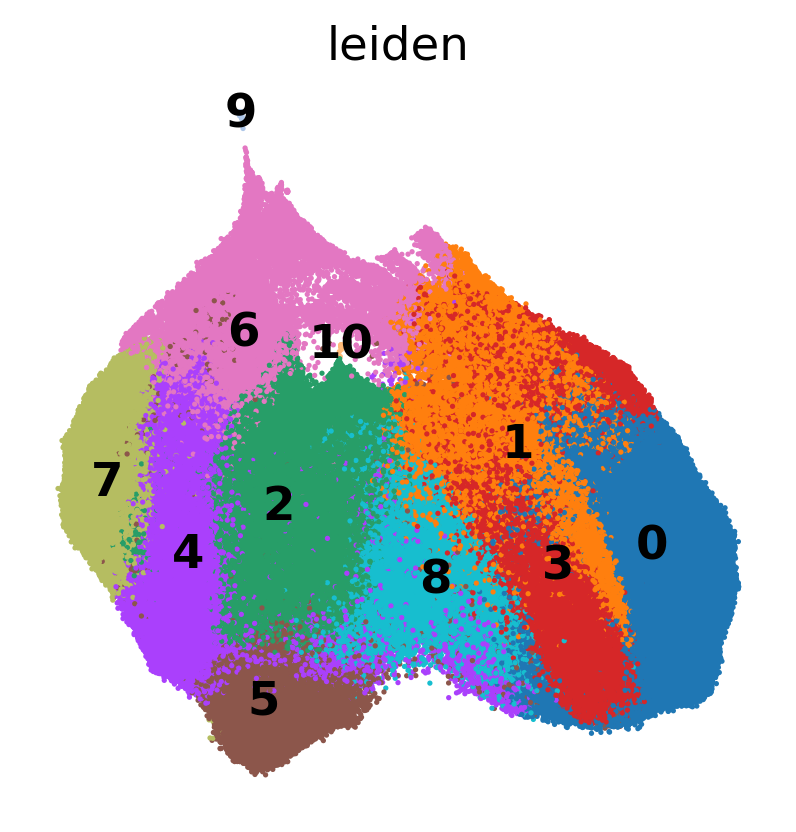

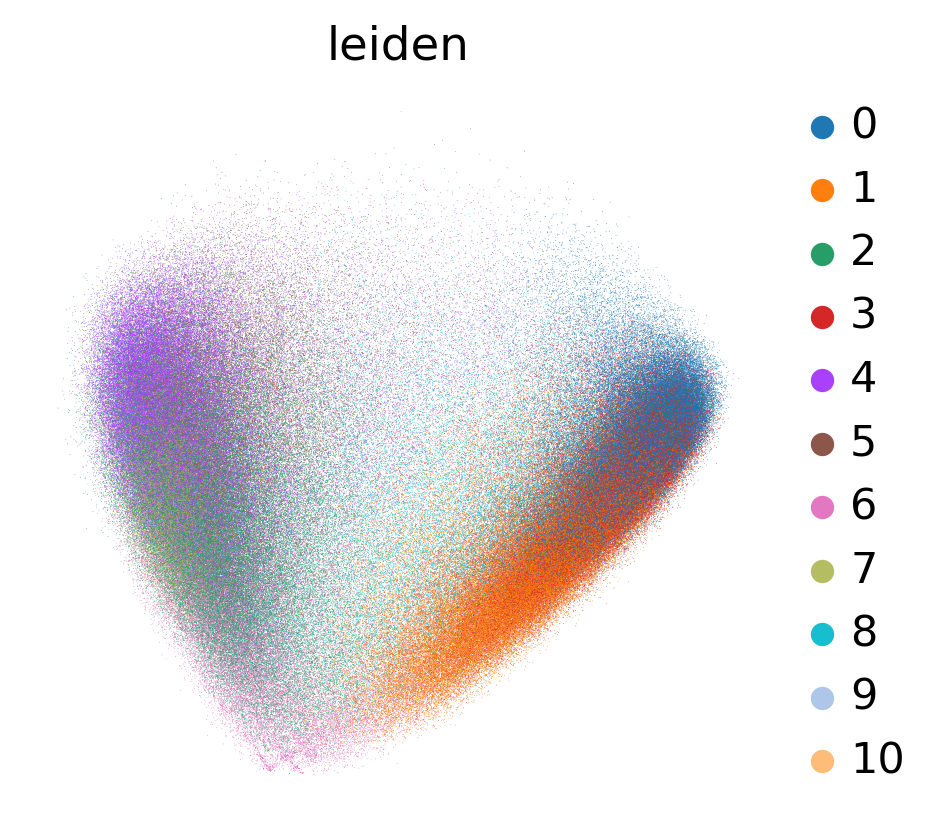

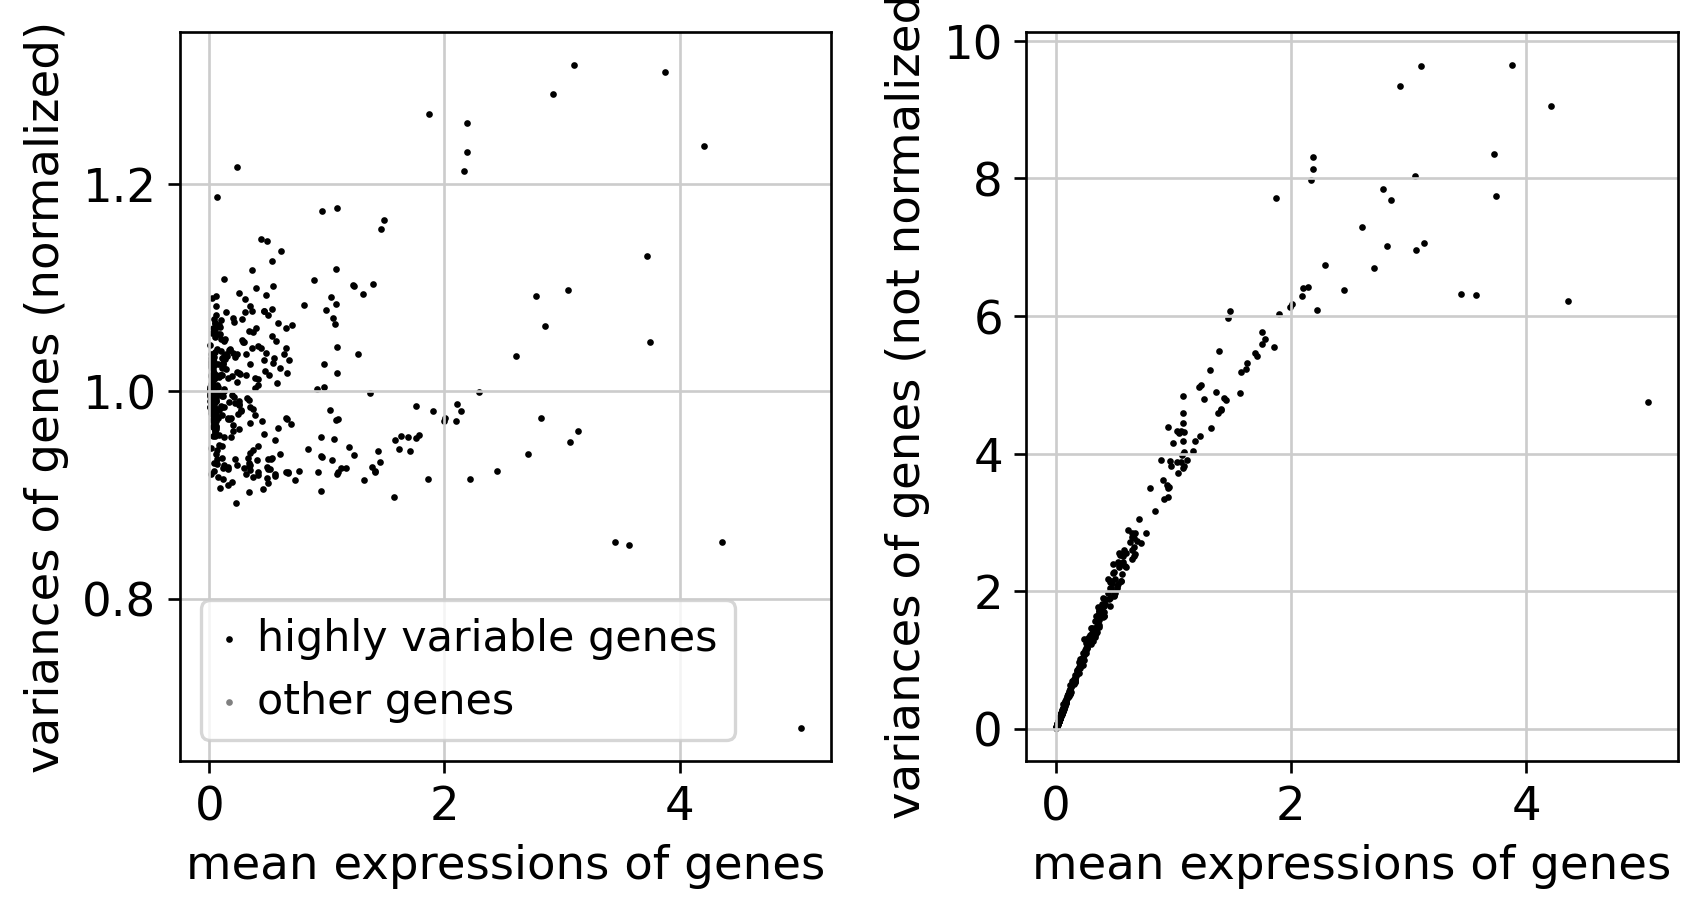

[OK] Figures saved to: /data/Data_for_Nuclass_training/Nuclass/preprocess_tutorial/Xenium_colon_wsi/Xenium_processed/original_0.2125mpp/Colon_Preview_Data_Cancer+pre-designed+add-on/work/qc
[OK] Processed AnnData saved to: /data/Data_for_Nuclass_training/Nuclass/preprocess_tutorial/Xenium_colon_wsi/Xenium_processed/original_0.2125mpp/Colon_Preview_Data_Cancer+pre-designed+add-on/work/adata.proc.h5ad and /data/Data_for_Nuclass_training/Nuclass/preprocess_tutorial/Xenium_colon_wsi/Xenium_processed/original_0.2125mpp/Colon_Preview_Data_Cancer+pre-designed+add-on/work/adata.use.h5ad


In [5]:
import numpy as np, pandas as pd, scanpy as sc
import matplotlib.pyplot as plt
from pathlib import Path

PLOT_DIR = (WORK_DIR / "qc").resolve()
PLOT_DIR.mkdir(parents=True, exist_ok=True)
sc.settings.figdir = str(PLOT_DIR)

adata = sc.read_h5ad(WORK_DIR / "adata.raw.h5ad")

# Try GPU acceleration via rapids-singlecell, otherwise fall back to CPU Scanpy.
USE_GPU = False
try:
    import rapids_singlecell as rsc
    import cupy as cp
    USE_GPU = True
    print(">>> Using GPU via rapids-singlecell.")
except Exception:
    print(">>> GPU not available, falling back to CPU Scanpy.")

proc_path = WORK_DIR / "adata.proc.h5ad"
use_path = WORK_DIR / "adata.use.h5ad"

if proc_path.exists() and use_path.exists():
    adata_proc = sc.read_h5ad(proc_path)
    adata_use = sc.read_h5ad(use_path)
else:
    # Normalize, log-transform, and select HVGs.
    sc.pp.normalize_total(adata, target_sum=1e4)
    sc.pp.log1p(adata)
    sc.pp.highly_variable_genes(adata, n_top_genes=2000, flavor="seurat_v3")

    # Preserve the raw counts before subsetting.
    adata.raw = adata

    # Work on HVGs for dimensionality reduction and clustering.
    adata_use = adata[:, adata.var["highly_variable"]].copy()

    if USE_GPU:
        rsc.pp.pca(adata_use, n_comps=30)
        rsc.pp.neighbors(adata_use, n_neighbors=15, n_pcs=30)
        rsc.tl.umap(adata_use, min_dist=0.3)
        rsc.tl.leiden(adata_use, resolution=0.6, key_added="leiden")
    else:
        sc.pp.pca(adata_use, n_comps=30, svd_solver="arpack")
        sc.pp.neighbors(adata_use, n_neighbors=15, n_pcs=30)
        sc.tl.umap(adata_use, min_dist=0.3)
        sc.tl.leiden(adata_use, resolution=0.6, key_added="leiden")

    # Copy embeddings and cluster labels back to the full AnnData object.
    adata.obs["leiden"] = adata_use.obs["leiden"].astype("category")
    adata.obsm["X_pca"] = adata_use.obsm["X_pca"]
    adata.obsm["X_umap"] = adata_use.obsm["X_umap"]

    # Persist processed objects for downstream steps.
    adata.write(proc_path, compression="lzf")
    adata_use.write(use_path, compression="lzf")
    adata_proc = adata

# Figures + coordinate export.
sc.pl.umap(
    adata_use,
    color="leiden",
    legend_loc="on data",
    frameon=False,
    s=10,
    show=True,
    save="_umap_leiden.png",
)
sc.pl.pca(
    adata_use,
    color="leiden",
    components=["1,2"],
    frameon=False,
    show=True,
    save="_pca12_leiden.png",
)
sc.pl.highly_variable_genes(adata_proc, show=True, save="_hvg.png")

umap_df = (
    pd.DataFrame(adata_use.obsm["X_umap"], index=adata_use.obs_names, columns=["UMAP1", "UMAP2"])
    .assign(cluster=adata_use.obs["leiden"].astype(str).values)
)
umap_df.to_csv(PLOT_DIR / "umap_coords_leiden.csv")
print(f"[OK] Figures saved to: {PLOT_DIR}")
print(f"[OK] Processed AnnData saved to: {proc_path} and {use_path}")


### Step 6 – Rank marker genes per Leiden cluster

Blend Wilcoxon and logistic-regression rankings to create a concise marker table saved to `markers_topN.csv`.

In [6]:
import numpy as np, pandas as pd, scanpy as sc

adata = sc.read_h5ad(WORK_DIR / "adata.proc.h5ad")

def _ensure_cols(df, need_cols):
    for c in need_cols:
        if c not in df.columns:
            df[c] = np.nan
    return df

def rank_markers(adata_in, groupby="leiden", n_top=50, logreg_max_iter=2000):
    sc.tl.rank_genes_groups(adata_in, groupby=groupby, method="wilcoxon", use_raw=False)
    df_w = sc.get.rank_genes_groups_df(adata_in, group=None)
    df_w = _ensure_cols(df_w, ["scores", "pvals_adj"])

    sc.tl.rank_genes_groups(adata_in, groupby=groupby, method="logreg", use_raw=False, max_iter=logreg_max_iter)
    df_l = sc.get.rank_genes_groups_df(adata_in, group=None)
    df_l = _ensure_cols(df_l, ["scores"])
    if "pvals_adj" not in df_l.columns:
        df_l["pvals_adj"] = np.nan

    def mean_rank(df):
        base = df[["group", "names", "scores"]].copy()
        out = (
            base.groupby(["group", "names"], observed=False)
            .agg(score=("scores", "mean"))
            .reset_index()
        )
        if "pvals_adj" in df.columns:
            pmin = (
                df[["group", "names", "pvals_adj"]]
                .groupby(["group", "names"], observed=False)
                .agg(p=("pvals_adj", "min"))
                .reset_index()
            )
            out = out.merge(pmin, on=["group", "names"], how="left")
        else:
            out["p"] = np.nan
        out["rank_in_group"] = (
            out.groupby("group", observed=False)["score"].rank(ascending=False, method="first")
        )
        return out

    mw = mean_rank(df_w).rename(
        columns={"score": "score_wilcox", "p": "p_wilcox", "rank_in_group": "rank_in_group_wilcox"}
    )
    ml = mean_rank(df_l).rename(
        columns={"score": "score_logreg", "p": "p_logreg", "rank_in_group": "rank_in_group_logreg"}
    )
    merged = (
        mw.merge(ml, on=["group", "names"], how="inner")
        .assign(rank_mean=lambda x: (x["rank_in_group_wilcox"] + x["rank_in_group_logreg"]) / 2)
        .sort_values(["group", "rank_mean"], kind="mergesort")
    )
    top = merged.groupby("group", observed=False, sort=False).head(n_top).reset_index(drop=True)
    return top

markers_top = rank_markers(adata, groupby="leiden", n_top=30, logreg_max_iter=2000)
markers_top.to_csv(OUT_DIR / "markers_topN.csv", index=False)
print(f"[SAVE] {OUT_DIR / 'markers_topN.csv'}")

# Print top-10 markers per cluster for quick inspection.
for g, sub in markers_top.groupby("group", observed=False):
    sub10 = sub.head(10).copy()
    cols = ["names", "score_wilcox", "score_logreg"]
    if "p_wilcox" in sub10.columns:
        cols.append("p_wilcox")
    if "p_logreg" in sub10.columns:
        cols.append("p_logreg")
    print(f"Cluster {g} top10:")
    print(sub10[cols].to_string(index=False))


[SAVE] /data/Data_for_Nuclass_training/Nuclass/preprocess_tutorial/Xenium_colon_wsi/Xenium_processed/original_0.2125mpp/Colon_Preview_Data_Cancer+pre-designed+add-on/markers_topN.csv
Cluster 0 top10:
  names  score_wilcox  score_logreg  p_wilcox  p_logreg
 GNPTAB    362.422729      2.136309       0.0       NaN
  EPCAM    277.538391      0.567125       0.0       NaN
   CD24    292.506439      0.345926       0.0       NaN
  C1QBP    266.285797      0.468381       0.0       NaN
  HMGB2    291.294739      0.320267       0.0       NaN
   RRM2    301.806152      0.277683       0.0       NaN
   TYMS    291.548462      0.260301       0.0       NaN
SLC12A2    273.145538      0.275776       0.0       NaN
   KRT8    263.962799      0.308559       0.0       NaN
 FERMT1    272.805481      0.214652       0.0       NaN
Cluster 1 top10:
  names  score_wilcox  score_logreg  p_wilcox  p_logreg
   CD24    223.649292      0.203450       0.0       NaN
  EPCAM    273.072540      0.177143       0.0       NaN

### Step 7a – Score neighborhood purity and marker margins

Compute unsupervised confidence scores that combine local neighborhood agreement with marker-set expression.

In [7]:
# -*- coding: utf-8 -*-
from pathlib import Path
from sklearn.neighbors import NearestNeighbors
import numpy as np, pandas as pd, scipy.sparse as sp, scanpy as sc

save_dir = OUT_DIR / "work" / "confidence"
save_dir.mkdir(parents=True, exist_ok=True)

adata = sc.read_h5ad(WORK_DIR / "adata.proc.h5ad")

# --- Neighbor purity -------------------------------------------------------
X = adata.obsm["X_pca"]
n_cells = X.shape[0]
k = min(50, n_cells)
nbrs = NearestNeighbors(n_neighbors=k, algorithm="auto").fit(X)
_, idx = nbrs.kneighbors(X)

leiden = adata.obs["leiden"]
clusters = (
    leiden.astype(str).values
    if not pd.api.types.is_categorical_dtype(leiden)
    else leiden.astype(str).values
)

nbr_labels = clusters[idx]
same = (nbr_labels == clusters[:, None]).sum(axis=1)
denom = max(k - 1, 1)
neighbor_purity = (same - 1) / denom

# --- Marker preparation -----------------------------------------------------
markers_top = pd.read_csv(OUT_DIR / "markers_topN.csv")

def _norm_gene(s: str) -> str:
    s = str(s).strip().upper()
    if "." in s and s.startswith(("ENSG", "ENSMUSG", "ENSDARG")):
        s = s.split(".")[0]
    return s

if "names_norm" in markers_top.columns:
    gene_col = "names_norm"
else:
    markers_top["names_norm"] = markers_top["names"].astype(str).map(_norm_gene)
    gene_col = "names_norm"

if getattr(adata, "raw", None) is not None:
    Xmat = adata.raw.X
    var_names = adata.raw.var_names
else:
    Xmat = adata.X
    var_names = adata.var_names

norm_vars = pd.Index([_norm_gene(g) for g in var_names])
gene_to_idx = {g: i for i, g in enumerate(norm_vars)}

def get_indices_for_group(top_df, group):
    sub = top_df.loc[top_df["group"].astype(str) == str(group), gene_col].tolist()
    idxs = [gene_to_idx[g] for g in sub if g in gene_to_idx]
    return np.array(sorted(set(idxs)), dtype=int)

if pd.api.types.is_categorical_dtype(adata.obs["leiden"]):
    groups = list(adata.obs["leiden"].cat.categories.astype(str))
else:
    groups = sorted(pd.unique(clusters).astype(str).tolist())

group_markers = {g: get_indices_for_group(markers_top, g) for g in groups}
hit_stats = {g: int(len(v)) for g, v in group_markers.items()}
print("[marker hits per cluster]", hit_stats)
empty_marker_groups = [g for g, idxs in group_markers.items() if len(idxs) == 0]
if empty_marker_groups:
    print(f"⚠️ No markers matched for clusters: {empty_marker_groups}")

Xexp = Xmat.tocsr() if sp.issparse(Xmat) else sp.csr_matrix(Xmat)

def mean_gene_set(mat_csr, idxs):
    if len(idxs) == 0:
        return np.zeros(mat_csr.shape[0], dtype=float)
    sub = mat_csr[:, idxs]
    return np.asarray(sub.mean(axis=1)).ravel()

scores_all = np.vstack([mean_gene_set(Xexp, group_markers[g]) for g in groups]).T
g_index = {g: i for i, g in enumerate(groups)}
own = np.array([scores_all[i, g_index[clusters[i]]] for i in range(len(clusters))])

mask = np.ones_like(scores_all, dtype=bool)
mask[np.arange(scores_all.shape[0]), [g_index[c] for c in clusters]] = False
second = np.where(
    mask.any(axis=1),
    scores_all[mask].reshape(scores_all.shape[0], -1).max(axis=1),
    np.zeros(scores_all.shape[0], dtype=float),
)

margin = own - second

m_mu = np.median(margin)
mad = np.median(np.abs(margin - m_mu))
if mad > 0:
    scale = 3 * mad
else:
    q1, q3 = np.percentile(margin, [25, 75])
    iqr = q3 - q1
    if iqr > 0:
        scale = 2 * iqr
        m_mu = 0.5 * (q1 + q3)
    else:
        std = margin.std()
        scale = 3 * std if std > 0 else 1.0

marker_margin = np.clip(0.5 + 0.5 * (margin - m_mu) / (scale + 1e-12), 0, 1)

confidence = 0.6 * neighbor_purity + 0.4 * marker_margin

adata.obs["neighbor_purity"] = neighbor_purity
adata.obs["marker_margin"] = marker_margin
adata.obs["confidence"] = confidence

df_conf = pd.DataFrame(
    {
        "cell_id": adata.obs_names.astype(str),
        "leiden": clusters,
        "neighbor_purity": neighbor_purity,
        "marker_margin": marker_margin,
        "confidence": confidence,
    }
)
out_csv = save_dir / "cell_confidence.csv"
df_conf.to_csv(out_csv, index=False)
print(f"✅ Saved: {out_csv}")


/tmp/ipykernel_926692/3884006233.py:21: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  if not pd.api.types.is_categorical_dtype(leiden)
/tmp/ipykernel_926692/3884006233.py:60: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(adata.obs["leiden"]):


[marker hits per cluster] {'0': 30, '1': 30, '2': 30, '3': 30, '4': 30, '5': 30, '6': 30, '7': 30, '8': 30, '9': 30, '10': 30}
✅ Saved: /data/Data_for_Nuclass_training/Nuclass/preprocess_tutorial/Xenium_colon_wsi/Xenium_processed/original_0.2125mpp/Colon_Preview_Data_Cancer+pre-designed+add-on/work/confidence/cell_confidence.csv


### Step 7b – Map clusters to biological labels and finalize confidences

Map Leiden clusters to curated biological labels, recompute marker margins at the label level, and persist the final confidence table plus the cluster→label mapping.

In [8]:
# -*- coding: utf-8 -*-
from pathlib import Path
from sklearn.neighbors import NearestNeighbors
import numpy as np, pandas as pd, scipy.sparse as sp, scanpy as sc

save_dir = OUT_DIR / "work" / "confidence"
save_dir.mkdir(parents=True, exist_ok=True)

adata = sc.read_h5ad(WORK_DIR / "adata.proc.h5ad")

# Map Leiden clusters to curated coarse labels for downstream supervision.
CLUSTER_LABELS = {
    0: "Malignant",
    1: "Macrophage",
    2: "Malignant",
    3: "Malignant",
    4: "Tumor_Associated_Fibroblast",
    5: "Endothelial",
    6: "Ambiguous/Low_confidence",
    7: "Smooth_Muscle",
    8: "Macrophage",
    9: "Ambiguous/Low_confidence",
    10: "Ambiguous/Low_confidence",
}
cluster_to_label = {str(k): v for k, v in CLUSTER_LABELS.items()}

X = adata.obsm["X_pca"]
n_cells = X.shape[0]
k = min(50, n_cells)
nbrs = NearestNeighbors(n_neighbors=k, algorithm="auto").fit(X)
_, idx = nbrs.kneighbors(X)

leiden = adata.obs["leiden"]
clusters = (
    leiden.astype(str).values
    if not pd.api.types.is_categorical_dtype(leiden)
    else leiden.astype(str).values
)

nbr_labels = clusters[idx]
same = (nbr_labels == clusters[:, None]).sum(axis=1)
denom = max(k - 1, 1)
neighbor_purity = (same - 1) / denom

final_labels = np.array([cluster_to_label.get(c, "Ambiguous/Low_confidence") for c in clusters], dtype=str)
adata.obs["final_label"] = pd.Categorical(final_labels)

markers_top = pd.read_csv(OUT_DIR / "markers_topN.csv")

def _norm_gene(s: str) -> str:
    s = str(s).strip().upper()
    if "." in s and s.startswith(("ENSG", "ENSMUSG", "ENSDARG")):
        s = s.split(".")[0]
    return s

if "names_norm" in markers_top.columns:
    gene_col = "names_norm"
else:
    markers_top["names_norm"] = markers_top["names"].astype(str).map(_norm_gene)
    gene_col = "names_norm"

if getattr(adata, "raw", None) is not None:
    Xmat = adata.raw.X
    var_names = adata.raw.var_names
else:
    Xmat = adata.X
    var_names = adata.var_names

norm_vars = pd.Index([_norm_gene(g) for g in var_names])
gene_to_idx = {g: i for i, g in enumerate(norm_vars)}

def get_indices_for_group(top_df, group):
    sub = top_df.loc[top_df["group"].astype(str) == str(group), gene_col].tolist()
    idxs = [gene_to_idx[g] for g in sub if g in gene_to_idx]
    return np.array(sorted(set(idxs)), dtype=int)

if pd.api.types.is_categorical_dtype(adata.obs["leiden"]):
    cluster_groups = list(adata.obs["leiden"].cat.categories.astype(str))
else:
    cluster_groups = sorted(pd.unique(clusters).astype(str).tolist())

cluster_markers = {g: get_indices_for_group(markers_top, g) for g in cluster_groups}

label_order = sorted(pd.unique(final_labels).tolist())
label_markers = {lab: set() for lab in label_order}
for g in cluster_groups:
    lab = cluster_to_label.get(g, "Ambiguous/Low_confidence")
    idxs = cluster_markers.get(g, np.array([], dtype=int))
    label_markers[lab].update(map(int, idxs))
label_markers = {lab: np.array(sorted(v), dtype=int) for lab, v in label_markers.items()}

hit_stats = {lab: int(len(v)) for lab, v in label_markers.items()}
print("[marker hits per final_label]", hit_stats)
empty_labels = [lab for lab, v in label_markers.items() if len(v) == 0]
if empty_labels:
    print(f"⚠️ No markers matched for labels: {empty_labels}")

Xexp = Xmat.tocsr() if sp.issparse(Xmat) else sp.csr_matrix(Xmat)

def mean_gene_set(mat_csr, idxs):
    if len(idxs) == 0:
        return np.zeros(mat_csr.shape[0], dtype=float)
    sub = mat_csr[:, idxs]
    return np.asarray(sub.mean(axis=1)).ravel()

scores_all = np.vstack([mean_gene_set(Xexp, label_markers[lab]) for lab in label_order]).T
label_index = {lab: i for i, lab in enumerate(label_order)}
own = np.array([scores_all[i, label_index[final_labels[i]]] for i in range(len(final_labels))])

mask = np.ones_like(scores_all, dtype=bool)
mask[np.arange(scores_all.shape[0]), [label_index[l] for l in final_labels]] = False
second = np.where(
    mask.any(axis=1),
    scores_all[mask].reshape(scores_all.shape[0], -1).max(axis=1),
    np.zeros(scores_all.shape[0], dtype=float),
)

margin = own - second

m_mu = np.median(margin)
mad = np.median(np.abs(margin - m_mu))
if mad > 0:
    scale = 3 * mad
else:
    q1, q3 = np.percentile(margin, [25, 75])
    iqr = q3 - q1
    if iqr > 0:
        scale = 2 * iqr
        m_mu = 0.5 * (q1 + q3)
    else:
        std = margin.std()
        scale = 3 * std if std > 0 else 1.0

marker_margin = np.clip(0.5 + 0.5 * (margin - m_mu) / (scale + 1e-12), 0, 1)

confidence = 0.6 * neighbor_purity + 0.4 * marker_margin

adata.obs["neighbor_purity"] = neighbor_purity
adata.obs["marker_margin"] = marker_margin
adata.obs["confidence"] = confidence
adata.obs["final_label"] = pd.Categorical(final_labels)

df_conf = pd.DataFrame(
    {
        "cell_id": adata.obs_names.astype(str),
        "leiden": clusters,
        "final_label": final_labels,
        "neighbor_purity": neighbor_purity,
        "marker_margin": marker_margin,
        "confidence": confidence,
    }
)
out_csv = save_dir / "cell_confidence.csv"
df_conf.to_csv(out_csv, index=False)
print(f"✅ Saved: {out_csv}")

pd.DataFrame({"cluster": list(cluster_to_label.keys()), "final_label": list(cluster_to_label.values())}).to_csv(
    save_dir / "cluster_to_label.csv", index=False
)
print(f"✅ Saved: {save_dir / 'cluster_to_label.csv'}")


/tmp/ipykernel_926692/1837425838.py:36: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  if not pd.api.types.is_categorical_dtype(leiden)
/tmp/ipykernel_926692/1837425838.py:77: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(adata.obs["leiden"]):


[marker hits per final_label] {'Ambiguous/Low_confidence': 69, 'Endothelial': 30, 'Macrophage': 52, 'Malignant': 63, 'Smooth_Muscle': 30, 'Tumor_Associated_Fibroblast': 30}
✅ Saved: /data/Data_for_Nuclass_training/Nuclass/preprocess_tutorial/Xenium_colon_wsi/Xenium_processed/original_0.2125mpp/Colon_Preview_Data_Cancer+pre-designed+add-on/work/confidence/cell_confidence.csv
✅ Saved: /data/Data_for_Nuclass_training/Nuclass/preprocess_tutorial/Xenium_colon_wsi/Xenium_processed/original_0.2125mpp/Colon_Preview_Data_Cancer+pre-designed+add-on/work/confidence/cluster_to_label.csv


### Step 8 – Export annotations, downsampled H&E, and QA views

Apply confidence filters, create the tutorial-friendly JSON annotations, save a 0.25 µm/px TIFF, and generate quick-look PNGs.

In [ ]:
# -*- coding: utf-8 -*-
import json, random
import numpy as np, pandas as pd
import tifffile
from PIL import Image, ImageDraw
import matplotlib.pyplot as plt, matplotlib
import scanpy as sc

# --- Output locations ------------------------------------------------------
OUT_RUN = RESAMPLED_ROOT / RUN_NAME
OUT_RUN.mkdir(parents=True, exist_ok=True)
IMG_TIF = OUT_RUN / "downsampled_image_0.25mpp.tif"
ANN_JSON = OUT_RUN / f"{JSON_PREFIX}_annotations_downsampled_0.25mpp.json"

adata = sc.read_h5ad(OUT_DIR / "work" / "adata.proc.h5ad")
with open(OUT_DIR / "work" / "metrics.json") as f:
    metrics = json.load(f)
mpp_mip = float(metrics["micron_per_mip_pixel"])

M = pd.read_csv(align_csv, header=None).values
Minv = np.linalg.inv(M)

# --- Derive fine-grained labels if not provided ----------------------------
if "cell_type_fine" not in adata.obs.columns:
    fine_map = {
        "0": "Epithelial_Tumor_Proliferative_KRT8_EPCAM",
        "1": "Macrophage_TAM_CTSB_CD14_CD163",
        "2": "Epithelial_Tumor_Secretory_SOX4_PIGR",
        "3": "Epithelial_Tumor_ID2_high",
        "4": "CAF_SFRP2_SFRP4_THBS2",
        "5": "Endothelial_PLVAP_PECAM1_VWF",
        "6": "Ambiguous/Low_confidence",
        "7": "Smooth_Muscle_TAGLN_ACTA2",
        "8": "Macrophage_TAM_C1QC_APOE",
        "9": "Ambiguous/Low_confidence",
        "10": "Ambiguous/Low_confidence",
    }
    cl = adata.obs["leiden"].astype(str)
    adata.obs["cell_type_fine"] = pd.Categorical([fine_map.get(c, f"cluster_{c}") for c in cl])

merge_map = {
    "Epithelial_Tumor_Proliferative_KRT8_EPCAM": "Malignant",
    "Epithelial_Tumor_Secretory_SOX4_PIGR": "Malignant",
    "Epithelial_Tumor_ID2_high": "Malignant",
    "Endothelial_PLVAP_PECAM1_VWF": "Endothelial",
    "CAF_SFRP2_SFRP4_THBS2": "Tumor_Associated_Fibroblast",
    "Macrophage_TAM_CTSB_CD14_CD163": "Macrophage",
    "Macrophage_TAM_C1QC_APOE": "Macrophage",
    "Smooth_Muscle_TAGLN_ACTA2": "Smooth_Muscle",
    "Ambiguous/Low_confidence": "Low_quality",
}
adata.obs["cell_type_merged"] = pd.Categorical(
    [merge_map.get(x, x) for x in adata.obs["cell_type_fine"].astype(str)]
)

# --- Coordinate transforms -------------------------------------------------
xy_um = adata.obs[["x_micron", "y_micron"]].to_numpy(float)
xs, ys = xy_um[:, 0] / mpp_mip, xy_um[:, 1] / mpp_mip
he_xy = (Minv @ np.vstack([xs, ys, np.ones_like(xs)])).T
he_x, he_y = he_xy[:, 0], he_xy[:, 1]

scale = float(np.sqrt(np.abs(np.linalg.det(M[:2, :2]))))
mpp_he = float(mpp_mip / scale)
s_down = mpp_he / MPP_TARGET
ds_x, ds_y = he_x * s_down, he_y * s_down

# --- Confidence-based filtering -------------------------------------------
conf_csv = OUT_DIR / "work" / "confidence" / "cell_confidence.csv"
conf_df = pd.read_csv(conf_csv, dtype={"cell_id": "string"})
conf_df["cell_id"] = conf_df["cell_id"].astype(str)
keep_id_by_conf = set(conf_df.loc[conf_df["confidence"] >= CONF_MIN, "cell_id"].tolist())

keep = adata.obs_names.astype(str).isin(keep_id_by_conf)
if "keep_for_export" in adata.obs.columns:
    keep &= adata.obs["keep_for_export"].astype(bool).values

EXCLUDE_FINE = {
    "Low_quality_or_doublet",
    "Ambiguous/Low_confidence",
}
EXCLUDE_MERGED = {
    "Low_quality",
}

fine_arr = adata.obs["cell_type_fine"].astype(str).values
merged_arr = adata.obs["cell_type_merged"].astype(str).values

leiden_arr = adata.obs["leiden"].astype(str).values
EXCLUDE_CLUSTERS = {"6", "9", "10"}
keep &= ~np.isin(leiden_arr, list(EXCLUDE_CLUSTERS))
keep &= ~np.isin(fine_arr, list(EXCLUDE_FINE))
keep &= ~np.isin(merged_arr, list(EXCLUDE_MERGED))

FORBIDDEN_SUBSTR = ("low_quality", "Low_quality", "Low_quality_or_doublet")
forbidden_mask = (
    np.array([any(s in t for s in FORBIDDEN_SUBSTR) for t in fine_arr])
    | np.array([any(s in t for s in FORBIDDEN_SUBSTR) for t in merged_arr])
)
keep &= ~forbidden_mask

remaining_fine = set(fine_arr[keep])
remaining_merged = set(merged_arr[keep])
assert "Low_quality_or_doublet" not in remaining_fine, "Low_quality_or_doublet should be filtered"
assert "Low_quality" not in remaining_merged, "Low_quality should be filtered"
assert len(remaining_fine & EXCLUDE_FINE) == 0, f"Filtered fine types still present: {remaining_fine & EXCLUDE_FINE}"
assert len(remaining_merged & EXCLUDE_MERGED) == 0, f"Filtered merged types still present: {remaining_merged & EXCLUDE_MERGED}"

# --- JSON export -----------------------------------------------------------
slide_id = SAMPLE
tissue_str = "Human Colon Cancer FFPE"
magnif = "40x"

json_dict = {}
for cid, x_px, y_px, (x_um, y_um), label, ok in zip(
    adata.obs_names.astype(str),
    ds_x,
    ds_y,
    xy_um,
    adata.obs["cell_type_merged"].astype(str).values,
    keep,
):
    if not ok:
        continue
    json_dict[cid] = {
        "micron_per_pixel": MPP_TARGET,
        "magnification": magnif,
        "image_modality": "bright field H&E",
        "slide_id": slide_id,
        "tissue_type": tissue_str,
        "patient_id": f"{slide_id}_patient_1",
        "has_padding_flags": False,
        "has_truncation_flags": False,
        "centroid_x": float(x_px),
        "centroid_y": float(y_px),
        "class_id": label,
        "micron_x_centroid": float(x_um),
        "micron_y_centroid": float(y_um),
    }

with open(ANN_JSON, "w") as f:
    json.dump(json_dict, f, indent=2)
print(f"✅ JSON saved: {ANN_JSON}  (cells kept: {len(json_dict)})")
print(f"✅ Remaining fine types:   {sorted(remaining_fine)}")
print(f"✅ Remaining merged types: {sorted(remaining_merged)}")

# --- Save downsampled H&E --------------------------------------------------
raw = np.squeeze(tifffile.imread(str(he_ome)))
if raw.ndim == 3 and raw.shape[0] in (3, 4):
    arr = np.transpose(raw, (1, 2, 0))[:, :, :3]
elif raw.ndim == 2:
    arr = np.stack([raw] * 3, axis=-1)
else:
    arr = raw[..., :3]

arr8 = ((arr - arr.min()) / (arr.max() - arr.min() + 1e-9) * 255).astype(np.uint8)
Hf, Wf = arr8.shape[:2]
dst_size = (int(round(Wf * s_down)), int(round(Hf * s_down)))
img_ds = Image.fromarray(arr8).resize(dst_size, Image.Resampling.LANCZOS)
tifffile.imwrite(str(IMG_TIF), np.array(img_ds), photometric="rgb", compression="deflate")
print(f"✅ TIF saved:  {IMG_TIF}  (size: {dst_size[1]}×{dst_size[0]})")

# --- Sample directory outputs ----------------------------------------------
SAMPLE_DIR = ORIG_ROOT / SAMPLE / "sample"
SAMPLE_DIR.mkdir(parents=True, exist_ok=True)

random.seed(RNG_SEED)
kept_idx = np.where(keep)[0]
img_full = Image.fromarray(arr8)
half = PATCH_SIZE // 2

if len(kept_idx) == 0:
    print("⚠️ No cells passed the strict filters; skipping patch export.")
else:
    saved = 0
    for i in random.sample(list(kept_idx), k=min(5, len(kept_idx))):
        cx, cy = int(round(he_x[i])), int(round(he_y[i]))
        x0, y0 = cx - half, cy - half
        x1, y1 = cx + half, cy + half
        if x0 < 0 or y0 < 0 or x1 > Wf or y1 > Hf:
            continue
        patch = img_full.crop((x0, y0, x1, y1)).copy()
        draw = ImageDraw.Draw(patch)
        label = str(adata.obs["cell_type_merged"].iloc[i])
        txt = f"{label}"
        try:
            tw = draw.textlength(txt)
        except Exception:
            tw = 7 * len(txt)
        th = 12
        draw.rectangle((2, 2, 2 + tw + 6, 2 + th + 6), fill=(255, 255, 255, 200))
        draw.text((5, 5), txt, fill=(0, 0, 0))
        out_patch = SAMPLE_DIR / f"sample_{saved + 1}_{adata.obs_names[i]}_{label.replace('/', '-')}_224.png"
        patch.save(out_patch)
        saved += 1
    print(f"✅ Saved random {saved} patches → {SAMPLE_DIR}")

# --- Overlay of a central crop ---------------------------------------------
target = 2000
win = int(min(target, Hf, Wf))
half_win = win // 2

cx, cy = Wf // 2, Hf // 2
x0 = max(0, cx - half_win)
y0 = max(0, cy - half_win)
x1 = min(Wf, x0 + win)
y1 = min(Hf, y0 + win)
x0 = max(0, x1 - win)
y0 = max(0, y1 - win)

crop = arr8[y0:y1, x0:x1, :]

xk_full = he_x[kept_idx]
yk_full = he_y[kept_idx]
m_in = (xk_full >= x0) & (xk_full < x1) & (yk_full >= y0) & (yk_full < y1)
sub_idx = kept_idx[m_in]

xk = he_x[sub_idx] - x0
yk = he_y[sub_idx] - y0
kept_ct_sub = np.array(adata.obs["cell_type_merged"].astype(str).values)[sub_idx]
uniq_ct = sorted(set(kept_ct_sub))

tab20 = matplotlib.cm.get_cmap("tab20", len(uniq_ct)).colors
ct2color = {ct: tab20[i] for i, ct in enumerate(uniq_ct)}

plt.figure(figsize=(6, 6), dpi=150)
plt.imshow(crop)
plt.axis("off")
for ct in uniq_ct:
    m = kept_ct_sub == ct
    if not np.any(m):
        continue
    plt.scatter(
        xk[m],
        yk[m],
        s=1.0,
        edgecolors="none",
        linewidths=0,
        c=[ct2color[ct]],
        rasterized=True,
    )

plt.legend(
    handles=[
        plt.Line2D([0], [0], marker='o', linestyle='', markersize=4, markerfacecolor=ct2color[ct], markeredgewidth=0, label=ct)
        for ct in uniq_ct
    ],
    loc="center left",
    bbox_to_anchor=(1.02, 0.5),
    fontsize=8,
    title="Cell type (kept)",
)

overlay_path = SAMPLE_DIR / "overlay_kept_tab20_center2000.png"
plt.tight_layout()
plt.savefig(overlay_path, dpi=200)
plt.close()
print(f"✅ Overlay (center {win}×{win}) saved: {overlay_path}  | points: {len(sub_idx)} / kept: {len(kept_idx)}")


### Step 9 – Extract 224 px and 1024 px patches

Run the consolidated patch extractor to build HDF5 containers under `extracted_patches/<sample>/all/`.

In [ ]:
# -*- coding: utf-8 -*-
"""
Extract 224x224 & 1024x1024 patches from the 0.25 mpp TIFF + JSON, save consolidated HDF5 files,
and copy the annotations into `Xenium_colon_wsi/Xenium_processed/extracted_patches/<SAMPLE>/all/`.
"""
import os, json, time, argparse
import numpy as np
import pandas as pd
import tifffile, h5py
from PIL import Image
from tqdm import tqdm
import multiprocessing
from multiprocessing import shared_memory

SAMPLE = SAMPLE
RESAMPLED_ROOT = RESAMPLED_ROOT
RUN_NAME = RUN_NAME
JSON_PREFIX = JSON_PREFIX

SRC_DIR = RESAMPLED_ROOT / RUN_NAME
INPUT_IMAGE_PATH = str(SRC_DIR / "downsampled_image_0.25mpp.tif")
INPUT_JSON_PATH = str(SRC_DIR / f"{JSON_PREFIX}_annotations_downsampled_0.25mpp.json")

DEST_ROOT = PATCH_ROOT
ALL_DIR = os.path.join(DEST_ROOT, SAMPLE, "all")
os.makedirs(ALL_DIR, exist_ok=True)
H5_224_PATH = os.path.join(ALL_DIR, "patches_224x224.h5")
H5_1024_PATH = os.path.join(ALL_DIR, "patches_1024x1024.h5")
ANN_JSON_OUT = os.path.join(ALL_DIR, "annotations.json")


def _default_workers():
    try:
        return int(os.environ.get("H5_WORKERS") or 64)
    except Exception:
        return 64


NUM_WORKERS = _default_workers()
os.environ.setdefault("OMP_NUM_THREADS", "1")
os.environ.setdefault("MKL_NUM_THREADS", "1")
os.environ.setdefault("OPENBLAS_NUM_THREADS", "1")
os.environ.setdefault("NUMEXPR_NUM_THREADS", "1")
Image.MAX_IMAGE_PIXELS = None

worker_shared_info = {}

def init_worker(shm_name, shape, dtype_str):
    global worker_shared_info
    worker_shared_info["shm"] = shared_memory.SharedMemory(name=shm_name)
    dtype = np.dtype(dtype_str)
    worker_shared_info["np_array"] = np.ndarray(shape, dtype=dtype, buffer=worker_shared_info["shm"].buf)


def extract_patch_with_padding(image, cx, cy, size):
    half = size // 2
    x0, y0 = int(round(cx - half)), int(round(cy - half))
    x1, y1 = x0 + size, y0 + size
    H, W = image.shape[:2]
    C = 1 if image.ndim == 2 else image.shape[2]
    out = np.zeros((size, size, C), dtype=image.dtype)
    ix0, iy0 = max(0, x0), max(0, y0)
    ix1, iy1 = min(W, x1), min(H, y1)
    px0, py0 = max(0, -x0), max(0, -y0)
    px1, py1 = px0 + (ix1 - ix0), py0 + (iy1 - iy0)
    if ix1 > ix0 and iy1 > iy0:
        if C == 1:
            out[py0:py1, px0:px1, 0] = image[iy0:iy1, ix0:ix1]
        else:
            out[py0:py1, px0:px1, :] = image[iy0:iy1, ix0:ix1]
    return out


def process_patch_worker_from_shm(args):
    idx, key, annot, sizes = args
    image_np = worker_shared_info['np_array']
    try:
        cx, cy = annot['centroid_x'], annot['centroid_y']
        out = {'idx': idx, 'key': key}
        if 224 in sizes:
            out['p224'] = extract_patch_with_padding(image_np, cx, cy, 224)
        if 1024 in sizes:
            out['p1024'] = extract_patch_with_padding(image_np, cx, cy, 1024)
        return out
    except Exception as e:
        print(f"[ERR] key={key}: {e}")
        return None


def main_extract(workers=NUM_WORKERS, compress_224='lzf', compress_1024=None, chunk_n=1):
    t0 = time.time()

    print(f"[LOAD] image: {INPUT_IMAGE_PATH}")
    img = tifffile.imread(INPUT_IMAGE_PATH)
    if img.ndim == 2:
        img = img[..., None]
    elif img.ndim == 3 and img.shape[0] in (3, 4):
        img = np.transpose(img, (1, 2, 0))
        img = img[..., :3]
    print(f"[LOAD] image shape: {img.shape}, dtype: {img.dtype}")

    print(f"[LOAD] annotations: {INPUT_JSON_PATH}")
    with open(INPUT_JSON_PATH, 'r') as f:
        anns = json.load(f)

    items = sorted(anns.items(), key=lambda x: x[0])
    N = len(items)

    if not os.path.exists(ANN_JSON_OUT):
        with open(ANN_JSON_OUT, 'w') as f:
            json.dump(anns, f, indent=2)
        print(f"[SAVE] {ANN_JSON_OUT}")

    shm = shared_memory.SharedMemory(create=True, size=img.nbytes)
    shared_arr = np.ndarray(img.shape, dtype=img.dtype, buffer=shm.buf)
    shared_arr[:] = img[:]
    del img

    os.makedirs(ALL_DIR, exist_ok=True)
    C = shared_arr.shape[2]
    need_224 = not os.path.exists(H5_224_PATH)
    need_1024 = not os.path.exists(H5_1024_PATH)

    h5_224 = None
    h5_1024 = None
    pool = None
    pbar = None

    try:
        if need_224:
            h5_224 = h5py.File(H5_224_PATH, 'w')
            d_img224 = h5_224.create_dataset(
                'images', shape=(N, 224, 224, C), dtype=shared_arr.dtype,
                chunks=(max(1, chunk_n), 224, 224, C), compression=compress_224
            )
            d_keys224 = h5_224.create_dataset('keys', shape=(N,), dtype=h5py.string_dtype('utf-8'))

        if need_1024:
            h5_1024 = h5py.File(H5_1024_PATH, 'w')
            d_img1k = h5_1024.create_dataset(
                'images', shape=(N, 1024, 1024, C), dtype=shared_arr.dtype,
                chunks=(max(1, chunk_n), 1024, 1024, C), compression=compress_1024
            )
            d_keys1k = h5_1024.create_dataset('keys', shape=(N,), dtype=h5py.string_dtype('utf-8'))

        sizes = []
        if need_224:
            sizes.append(224)
        if need_1024:
            sizes.append(1024)
        if not sizes:
            print("[SKIP] patches already exist. Done.")
            return

        tasks = [(i, k, a, sizes) for i, (k, a) in enumerate(items)]
        chunksize = 64 if len(tasks) > 10000 else 8
        print(f"[MP] workers={workers}  chunksize={chunksize}  sizes={sizes}")

        pool = multiprocessing.Pool(
            processes=workers,
            initializer=init_worker,
            initargs=(shm.name, shared_arr.shape, str(shared_arr.dtype)),
            maxtasksperchild=2000,
        )
        pbar = tqdm(total=len(tasks), desc="Extract", ncols=100)

        for res in pool.imap_unordered(process_patch_worker_from_shm, tasks, chunksize=chunksize):
            if res is None:
                pbar.update(1)
                continue
            i = res['idx']
            k = res['key']
            if need_224 and 'p224' in res:
                d_img224[i] = res['p224']
                d_keys224[i] = k
            if need_1024 and 'p1024' in res:
                d_img1k[i] = res['p1024']
                d_keys1k[i] = k
            pbar.update(1)

        pool.close()
        pool.join()
        pool = None

    finally:
        if pbar is not None:
            pbar.close()
        if pool is not None:
            try:
                pool.close()
            except Exception:
                pass
            try:
                pool.terminate()
            except Exception:
                pass
            try:
                pool.join()
            except Exception:
                pass
        try:
            if h5_224 is not None:
                h5_224.flush()
                h5_224.close()
        except Exception:
            pass
        try:
            if h5_1024 is not None:
                h5_1024.flush()
                h5_1024.close()
        except Exception:
            pass
        try:
            shm.close()
        except Exception:
            pass
        try:
            shm.unlink()
        except Exception:
            pass

    elapsed_min = (time.time() - t0) / 60
    print(f"[DONE] saved to {ALL_DIR}  | time={elapsed_min:.2f} min")


if __name__ == "__main__":
    try:
        multiprocessing.set_start_method('fork')
    except RuntimeError:
        pass
    main_extract(workers=NUM_WORKERS, compress_224='lzf', compress_1024=None, chunk_n=1)


### Step 10 – Split consolidated patches into train/test ROIs

Carve out a central ROI for held-out evaluation, duplicate annotations, and materialize per-patch HDF5 files for both splits.

In [ ]:
# -*- coding: utf-8 -*-
"""
Split consolidated HDF5 files plus annotations into train/test splits based on a central ROI.
Inputs:  Xenium_colon_wsi/Xenium_processed/extracted_patches/<SAMPLE>/all/
Outputs: Xenium_colon_wsi/Xenium_processed/extracted_patches/<SAMPLE>/{train,test}/
"""
import os, json, time, argparse
import numpy as np
import pandas as pd
import h5py
from tqdm import tqdm

SAMPLE = SAMPLE
DEST_ROOT = PATCH_ROOT
ALL_DIR = os.path.join(DEST_ROOT, SAMPLE, "all")
TRAIN_DIR = os.path.join(DEST_ROOT, SAMPLE, "train")
TEST_DIR = os.path.join(DEST_ROOT, SAMPLE, "test")
os.makedirs(TRAIN_DIR, exist_ok=True)
os.makedirs(TEST_DIR, exist_ok=True)

PATCH_SIZES = [224, 1024]


def is_consolidated_h5(h5f: h5py.File) -> bool:
    return ("images" in h5f) and ("keys" in h5f)


def load_annotations(source_dir: str) -> dict:
    cand = os.path.join(source_dir, "annotations.json")
    if not os.path.exists(cand):
        jsons = [os.path.join(source_dir, f) for f in os.listdir(source_dir) if f.lower().endswith('.json')]
        if len(jsons) != 1:
            raise FileNotFoundError(f"annotations.json missing in {source_dir}")
        cand = jsons[0]
    with open(cand, 'r') as f:
        return json.load(f)


def save_annotations(dest_dir: str, anns: dict):
    os.makedirs(dest_dir, exist_ok=True)
    with open(os.path.join(dest_dir, 'annotations.json'), 'w') as f:
        json.dump(anns, f, ensure_ascii=False, indent=2)


def select_central_roi_cells(df: pd.DataFrame, target_frac=0.25, min_frac=0.20, max_frac=0.30):
    x_min, x_max = df['centroid_x'].min(), df['centroid_x'].max()
    y_min, y_max = df['centroid_y'].min(), df['centroid_y'].max()
    bbox_w, bbox_h = (x_max - x_min), (y_max - y_min)
    cx, cy = x_min + bbox_w / 2.0, y_min + bbox_h / 2.0

    fracs = np.unique(np.append(np.linspace(min_frac, max_frac, 11), target_frac))
    xs, ys = df['centroid_x'].values, df['centroid_y'].values
    n = len(df)

    best_mask, best_diff, best_actual = None, 1e9, 0.0
    for f in fracs:
        scale = np.sqrt(max(1e-6, min(1.0, f)))
        w, h = bbox_w * scale, bbox_h * scale
        x0, x1 = cx - w / 2.0, cx + w / 2.0
        y0, y1 = cy - h / 2.0, cy + h / 2.0
        mask = (xs >= x0) & (xs < x1) & (ys >= y0) & (ys < y1)
        actual = mask.sum() / max(1, n)
        diff = abs(actual - target_frac)
        if diff < best_diff:
            best_mask, best_diff, best_actual = mask, diff, actual
    print(f"[SPLIT] Central ROI fraction ~ {best_actual:.3f} (target {target_frac}, range {min_frac}-{max_frac})")
    return best_mask


def copy_h5_subset_from_consolidated(src_path: str, dst_path: str, keys: list, compression='lzf'):
    with h5py.File(src_path, 'r') as src, h5py.File(dst_path, 'w') as dst:
        images = src['images']
        key_ds = src['keys'][:]
        key_map = {
            (k.decode('utf-8') if isinstance(k, (bytes, bytearray)) else str(k)): i
            for i, k in enumerate(key_ds)
        }
        for k in tqdm(keys, desc=f"Copy {os.path.basename(src_path)}", ncols=100):
            idx = key_map.get(k)
            if idx is None:
                continue
            dst.create_dataset(k, data=images[idx], compression=compression)


def run_split(target_frac=0.25, min_frac=0.20, max_frac=0.30, compression='lzf'):
    t0 = time.time()
    anns = load_annotations(ALL_DIR)
    df = pd.DataFrame.from_dict(anns, orient='index')
    print(f"[INFO] cells: {len(df)}  from {ALL_DIR}/annotations.json")

    test_mask = select_central_roi_cells(df, target_frac, min_frac, max_frac)
    test_ids = df.index[test_mask].tolist()
    train_ids = df.index[~test_mask].tolist()
    print(f"[INFO] Train={len(train_ids)}  Test={len(test_ids)}")

    save_annotations(TRAIN_DIR, {k: anns[k] for k in train_ids})
    save_annotations(TEST_DIR, {k: anns[k] for k in test_ids})

    for size in PATCH_SIZES:
        src_h5 = os.path.join(ALL_DIR, f"patches_{size}x{size}.h5")
        if not os.path.exists(src_h5):
            print(f"[WARN] missing {src_h5}, skip.")
            continue
        dst_train = os.path.join(TRAIN_DIR, f"patches_{size}x{size}.h5")
        dst_test = os.path.join(TEST_DIR, f"patches_{size}x{size}.h5")
        if os.path.exists(dst_train) and os.path.exists(dst_test):
            print(f"[SKIP] exists for {size}.")
            continue
        copy_h5_subset_from_consolidated(src_h5, dst_train, train_ids, compression=compression)
        copy_h5_subset_from_consolidated(src_h5, dst_test, test_ids, compression=compression)

    print(f"[DONE] split saved to:{TRAIN_DIR}{TEST_DIR}Time={ (time.time()-t0)/60:.2f } min")

run_split(target_frac=0.25, min_frac=0.20, max_frac=0.30, compression='lzf')


### Step 11 – (Optional) Spot-check extracted assets

Double-check that the consolidated HDF5 files and annotation JSON remain synchronized after extraction.

In [ ]:
import os, json, h5py

print("224 exists:", os.path.exists(H5_224_PATH), "sizeGB:", os.path.getsize(H5_224_PATH) / 1e9 if os.path.exists(H5_224_PATH) else 0)
print("1024 exists:", os.path.exists(H5_1024_PATH), "sizeGB:", os.path.getsize(H5_1024_PATH) / 1e9 if os.path.exists(H5_1024_PATH) else 0)
print("ann json exists:", os.path.exists(ANN_JSON_OUT))

with open(ANN_JSON_OUT) as f:
    anns = json.load(f)
N_json = len(anns)

if os.path.exists(H5_224_PATH):
    with h5py.File(H5_224_PATH, "r") as f:
        print("224 images:", f["images"].shape, f["images"].dtype, "keys:", f["keys"].shape)
        assert f["images"].shape[0] == N_json

if os.path.exists(H5_1024_PATH):
    with h5py.File(H5_1024_PATH, "r") as f:
        print("1024 images:", f["images"].shape, f["images"].dtype, "keys:", f["keys"].shape)
        assert f["images"].shape[0] == N_json
